In [1]:
from utils import get_charac_and_metric
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
def convert_into_data(global_delta_metric, charac_lists, all_models, all_transfo, target_metric) :
    """
    Convertit les données en un panda dataframe de la forme dont les colonnes sont :
    X : dataset, carac1, carac2, ..., caracN
    y : model1_method1, model1_method2, ..., model1_methodN, model2_method1, ..., modelN_methodN
    """
    #Récupère la liste des datasets
    datasets = list(global_delta_metric[target_metric].keys())

    #Récupère la liste des caractéristiques
    caracs = list(charac_lists.keys())

    #Crée le panda dataframe
    X = pd.DataFrame(columns = caracs)
    y = pd.DataFrame(columns = [f"{model}_{method}" for model in all_models for method in all_transfo])

    #Remplit le panda dataframe
    index_cursor = 0
    for dataset in datasets :
        try :
            charac_dataset = np.array( [charac_lists[carac][dataset] for carac in caracs] )
            X.loc[index_cursor] = [charac_lists[carac][dataset] for carac in caracs]
            y.loc[index_cursor] = [global_delta_metric[target_metric][dataset][model][method] for model in all_models for method in all_transfo]
            
        except :
            X.loc[index_cursor] = np.nan
            y.loc[index_cursor] = np.nan
            
        index_cursor += 1

    #Remplace Nan par la moyenne de chaque colonne
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    #Check if still Nan
    assert not(X.isnull().values.any()), f"X possède encore des Nan values : {X.isnull().sum().sum()}"
    assert not(y.isnull().values.any()), f"y possède encore des Nan values : {y.isnull().sum().sum()}"

    #Rajoute la colonne Dataset
    X["Dataset"] = datasets

    return X,y


In [3]:
global_delta_metric, charac_lists, _, all_models, all_transfo = get_charac_and_metric()
X_data, y_data = convert_into_data(global_delta_metric, charac_lists, all_models, all_transfo, 'F1')


================== RECAPITULATIF DES TESTS EFFECTUÉS ==================
Nombre de datasets : 634
Répartition des modèles : {'NN': 633, 'RF': 541, 'TS-RF': 490, 'DTW_NEIGBOURS': 389}
Répartition des transformations : {'Default': 634, 'ROS': 634, 'Jit': 634, 'TW': 634, 'Basic': 634, 'Ada': 369, 'DTW-SMOTE': 634}
Nombre de datasets après suppression : 634



In [4]:
X_data

,Length,Dataset size,Avg label size,Dataset variance,Intra-class variance,Dispersion smoothness,Bhattacharyya,Mean smoothness,DN_HistogramMode_5,DN_HistogramMode_10,...,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,Number of periods,ID,Dataset
0,407.51671,196.663239,65.416495,2.872738,0.877355,0.009192,1.225567e-01,0.080456,-0.097765,-0.165704,...,0.864058,21.895212,1.447587,0.478949,0.618997,0.213377,0.405884,1.509535,0.394812,MiddlePhalanxTW_RUS_0_50
1,407.51671,196.663239,65.416495,2.872738,0.877355,0.009192,1.225567e-01,0.080456,-0.097765,-0.165704,...,0.864058,21.895212,1.447587,0.478949,0.618997,0.213377,0.405884,1.509535,0.394812,Crop_RUS_0_20
2,448.00000,50.000000,16.666667,0.000306,0.000102,0.000168,9.716854e-08,0.009390,-0.022178,-0.263360,...,0.995134,107.020000,1.280245,0.346957,0.302609,0.024544,0.085616,1.120000,0.242729,Meat_RUS_0_50
3,512.00000,15.000000,7.500000,0.130218,0.065109,0.000627,5.168683e-25,0.022874,-0.200847,-0.129706,...,0.997072,38.600000,1.364741,0.492754,0.375362,0.079358,0.194617,2.666667,0.221742,BeetleFly_RUS_0_50
4,407.51671,196.663239,65.416495,2.872738,0.877355,0.009192,1.225567e-01,0.080456,-0.097765,-0.165704,...,0.864058,21.895212,1.447587,0.478949,0.618997,0.213377,0.405884,1.509535,0.394812,Wafer_RUS_1_20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,84.00000,18.000000,9.000000,0.109887,0.054943,0.000093,2.347534e-17,0.112380,0.011241,0.148171,...,0.751087,21.777778,1.497835,0.680135,0.550505,0.389972,0.586260,0.777778,0.072728,MoteStrain_RUS_1_20
630,60.00000,275.000000,45.833333,0.141434,0.023572,0.090405,5.078511e-03,0.235081,0.088950,0.091965,...,0.653387,4.770909,1.896415,0.573007,0.517483,0.346289,0.726505,0.389091,0.258427,SyntheticControl_RUS_0_50
631,65.00000,21.000000,10.500000,0.096280,0.048140,0.005271,8.077348e-24,0.157970,-0.239759,-0.134482,...,0.342698,5.238095,1.892089,0.428571,0.474427,0.771373,1.188064,2.095238,0.288755,SonyAIBORobotSurface2_RUS_0_50
632,407.51671,196.663239,65.416495,2.872738,0.877355,0.009192,1.225567e-01,0.080456,-0.097765,-0.165704,...,0.864058,21.895212,1.447587,0.478949,0.618997,0.213377,0.405884,1.509535,0.394812,ProximalPhalanxTW


# PCA & t-SNE

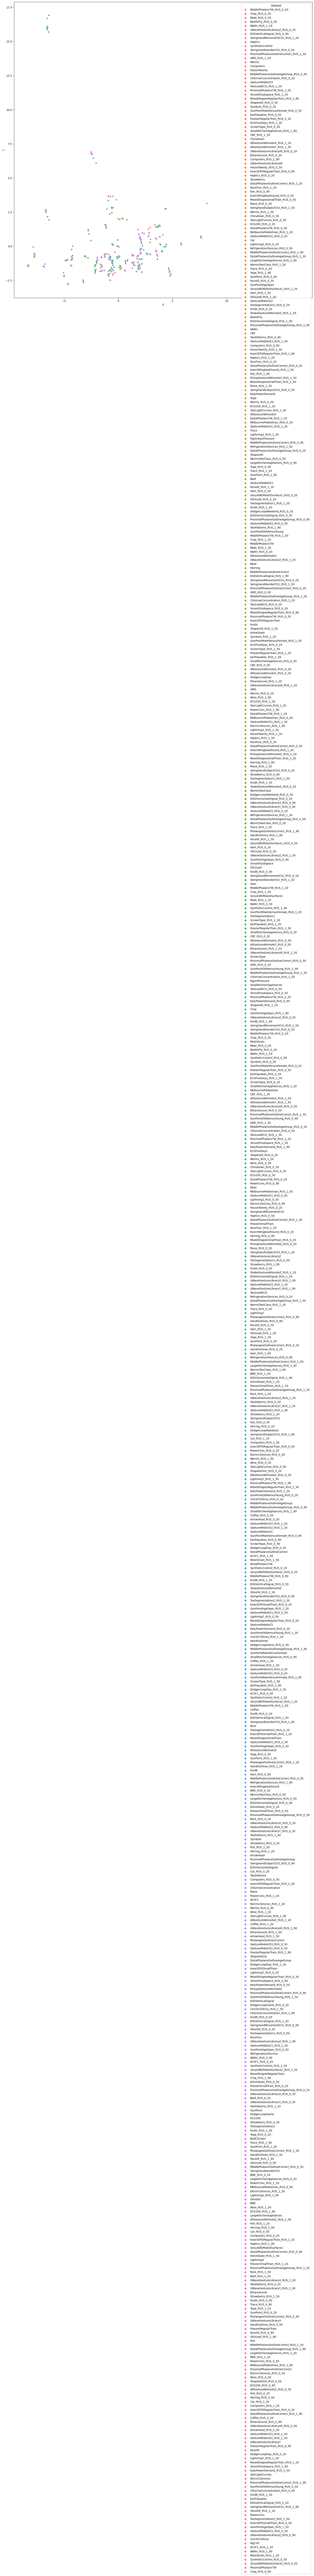

In [10]:
# PCA of X, the dataset must be plot near the same point, normalize my data

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(20,20))
scaler = StandardScaler()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X_data.drop(columns=['Dataset'])))
X_pca = pd.DataFrame(X_pca)
X_pca["Dataset"] = X_data["Dataset"]
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=X_pca["Dataset"])

plt.show()

/Users/dorian.joubaud/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/dorian.joubaud/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


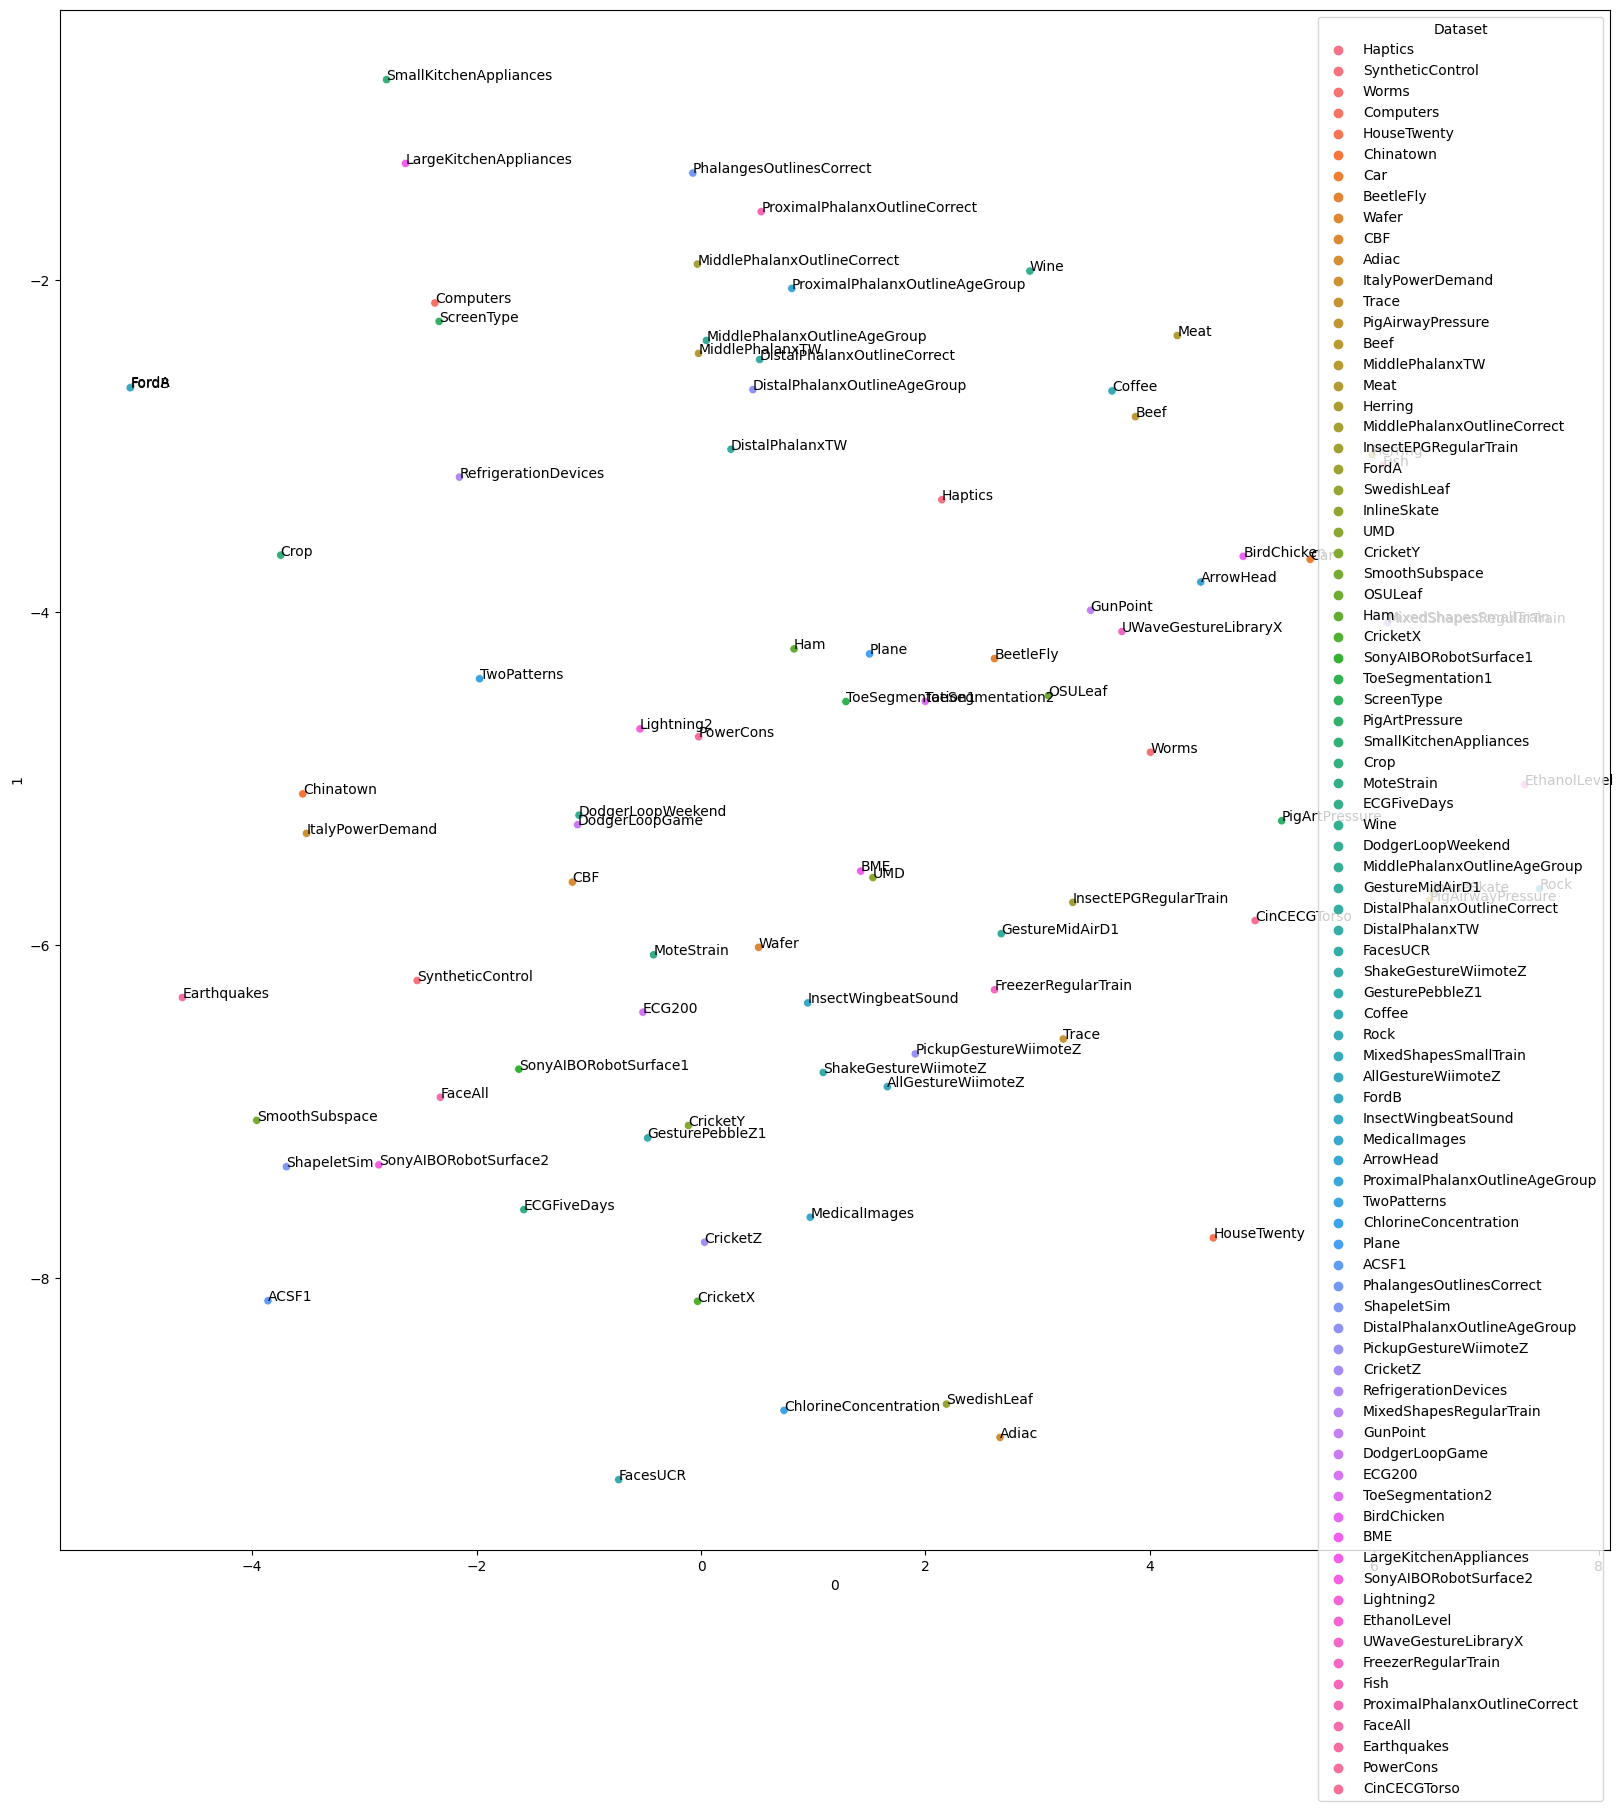

In [8]:
from sklearn.manifold import TSNE
fig = plt.figure(figsize=(20,20))
tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(scaler.fit_transform(X.drop(columns=['Dataset'])))
X_2d = pd.DataFrame(X_2d)
X_2d["Dataset"] = X["Dataset"]
sns.scatterplot(x=X_2d[0], y=X_2d[1], hue=X_2d["Dataset"])
for i, txt in enumerate(X_pca["Dataset"]):
    plt.annotate(txt, (X_2d[0][i], X_2d[1][i]))
plt.show()

## Weirdo

## Model based on Keras BNN page


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp


# Loading Model

In [5]:
# Loading model
model = tf.keras.models.load_model('models/model.h5')
model.summary()

2023-07-28 10:13:36.828307: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-07-28 10:13:36.828330: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-07-28 10:13:36.828334: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-07-28 10:13:36.828364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-28 10:13:36.828380: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               22016     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131072    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       

# SHAP




In [7]:
import shap
shap.initjs()
from sklearn.preprocessing import MinMaxScaler

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [8]:
X = pd.read_csv("data_condi.csv",sep=',')
y = pd.read_csv("target_condi.csv",sep=',')
   
   # Normalize the data per feature exept the dummy variables
df_encoded = X.drop(columns=['Dataset'])
    
dummy_columns = ['model', 'method']

    # Create a MinMaxScaler object
scaler = MinMaxScaler()

    # Get the subset of the dataframe with only the non-dummy columns
df_non_dummy = df_encoded.drop(dummy_columns, axis=1)

    # Apply normalization per feature (column) to the non-dummy columns
df_normalized = pd.DataFrame(scaler.fit_transform(df_non_dummy), columns=df_non_dummy.columns)

    # Combine the normalized non-dummy columns with the original dummy columns
df_encoded_normalized = pd.concat([df_normalized, df_encoded[dummy_columns]], axis=1)
df_encoded_normalized = pd.get_dummies(df_encoded_normalized, columns=['model', 'method'])
    


y_one = y["F1"]

In [9]:
f(df_encoded_normalized.iloc[:50,:])

NameError: name 'f' is not defined

In [10]:
df_encoded_normalized 

,Length,Dataset size,Avg label size,Dataset variance,Intra-class variance,Dispersion smoothness,Bhattacharyya,Mean smoothness,DN_HistogramMode_5,DN_HistogramMode_10,...,model_NN,model_RF,model_TS-RF,method_Ada,method_Basic,method_DTW-SMOTE,method_Default,method_Jit,method_ROS,method_TW
0,0.138748,0.102275,0.07062,0.026268,0.024067,0.052351,0.151454,0.14682,0.298293,0.459674,...,1,0,0,0,0,0,1,0,0,0
1,0.138748,0.102275,0.07062,0.026268,0.024067,0.052351,0.151454,0.14682,0.298293,0.459674,...,1,0,0,0,0,0,0,0,1,0
2,0.138748,0.102275,0.07062,0.026268,0.024067,0.052351,0.151454,0.14682,0.298293,0.459674,...,1,0,0,0,0,0,0,1,0,0
3,0.138748,0.102275,0.07062,0.026268,0.024067,0.052351,0.151454,0.14682,0.298293,0.459674,...,1,0,0,0,0,0,0,0,0,1
4,0.138748,0.102275,0.07062,0.026268,0.024067,0.052351,0.151454,0.14682,0.298293,0.459674,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17747,0.138748,0.102275,0.07062,0.026268,0.024067,0.052351,0.151454,0.14682,0.298293,0.459674,...,0,0,0,0,0,0,0,1,0,0
17748,0.138748,0.102275,0.07062,0.026268,0.024067,0.052351,0.151454,0.14682,0.298293,0.459674,...,0,0,0,0,0,0,0,0,0,1
17749,0.138748,0.102275,0.07062,0.026268,0.024067,0.052351,0.151454,0.14682,0.298293,0.459674,...,0,0,0,0,1,0,0,0,0,0
17750,0.138748,0.102275,0.07062,0.026268,0.024067,0.052351,0.151454,0.14682,0.298293,0.459674,...,0,0,0,1,0,0,0,0,0,0


In [12]:
df_encoded_normalized.iloc[:300,:].shape

(300, 43)

In [11]:
explainer = shap.Explainer(model.predict, df_encoded_normalized)

In [12]:
shap_values = explainer(df_encoded_normalized.iloc[:50,:])

 13/152 [=>............................] - ETA: 0s 

2023-07-28 10:14:30.971635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 4ms/step


Permutation explainer:   6%|▌         | 3/50 [00:00<?, ?it/s]

96/96 [==============================] - 0s 3ms/step


Permutation explainer:  10%|█         | 5/50 [00:14<01:07,  1.51s/it]

94/94 [==============================] - 0s 3ms/step


Permutation explainer:  12%|█▏        | 6/50 [00:17<01:34,  2.14s/it]

94/94 [==============================] - 0s 4ms/step


Permutation explainer:  14%|█▍        | 7/50 [00:20<01:48,  2.51s/it]

93/93 [==============================] - 0s 4ms/step


Permutation explainer:  16%|█▌        | 8/50 [00:23<01:55,  2.74s/it]

91/91 [==============================] - 0s 3ms/step


Permutation explainer:  18%|█▊        | 9/50 [00:26<01:56,  2.85s/it]

94/94 [==============================] - 0s 4ms/step


Permutation explainer:  20%|██        | 10/50 [00:29<01:57,  2.94s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  22%|██▏       | 11/50 [00:32<01:58,  3.03s/it]

93/93 [==============================] - 0s 4ms/step


Permutation explainer:  24%|██▍       | 12/50 [00:35<01:55,  3.04s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  26%|██▌       | 13/50 [00:39<01:54,  3.09s/it]

93/93 [==============================] - 0s 4ms/step


Permutation explainer:  28%|██▊       | 14/50 [00:42<01:53,  3.15s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  30%|███       | 15/50 [00:45<01:52,  3.20s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  32%|███▏      | 16/50 [00:49<01:52,  3.31s/it]

94/94 [==============================] - 0s 3ms/step


Permutation explainer:  34%|███▍      | 17/50 [00:52<01:47,  3.24s/it]

89/89 [==============================] - 0s 4ms/step


Permutation explainer:  36%|███▌      | 18/50 [00:55<01:42,  3.22s/it]

90/90 [==============================] - 0s 3ms/step


Permutation explainer:  38%|███▊      | 19/50 [00:58<01:41,  3.29s/it]

94/94 [==============================] - 0s 3ms/step


Permutation explainer:  40%|████      | 20/50 [01:02<01:37,  3.26s/it]

95/95 [==============================] - 0s 3ms/step


Permutation explainer:  42%|████▏     | 21/50 [01:05<01:35,  3.31s/it]

96/96 [==============================] - 0s 4ms/step


Permutation explainer:  44%|████▍     | 22/50 [01:09<01:34,  3.37s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  46%|████▌     | 23/50 [01:12<01:29,  3.33s/it]

94/94 [==============================] - 0s 4ms/step


Permutation explainer:  48%|████▊     | 24/50 [01:15<01:25,  3.27s/it]

97/97 [==============================] - 0s 4ms/step


Permutation explainer:  50%|█████     | 25/50 [01:18<01:23,  3.33s/it]

94/94 [==============================] - 0s 4ms/step


Permutation explainer:  52%|█████▏    | 26/50 [01:22<01:19,  3.33s/it]

92/92 [==============================] - 0s 3ms/step


Permutation explainer:  54%|█████▍    | 27/50 [01:25<01:15,  3.28s/it]

92/92 [==============================] - 0s 3ms/step


Permutation explainer:  56%|█████▌    | 28/50 [01:28<01:11,  3.26s/it]

95/95 [==============================] - 0s 4ms/step


Permutation explainer:  58%|█████▊    | 29/50 [01:31<01:07,  3.22s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  60%|██████    | 30/50 [01:34<01:03,  3.18s/it]

93/93 [==============================] - 0s 3ms/step


Permutation explainer:  62%|██████▏   | 31/50 [01:37<00:59,  3.12s/it]

95/95 [==============================] - 0s 4ms/step


Permutation explainer:  64%|██████▍   | 32/50 [01:40<00:56,  3.13s/it]

95/95 [==============================] - 0s 3ms/step


Permutation explainer:  66%|██████▌   | 33/50 [01:44<00:53,  3.12s/it]

96/96 [==============================] - 0s 3ms/step


Permutation explainer:  68%|██████▊   | 34/50 [01:47<00:50,  3.13s/it]

92/92 [==============================] - 0s 3ms/step


Permutation explainer:  70%|███████   | 35/50 [01:50<00:47,  3.14s/it]

93/93 [==============================] - 0s 4ms/step


Permutation explainer:  72%|███████▏  | 36/50 [01:53<00:43,  3.10s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  74%|███████▍  | 37/50 [01:56<00:40,  3.09s/it]

94/94 [==============================] - 0s 3ms/step


Permutation explainer:  76%|███████▌  | 38/50 [01:59<00:37,  3.14s/it]

95/95 [==============================] - 0s 3ms/step


Permutation explainer:  78%|███████▊  | 39/50 [02:02<00:34,  3.15s/it]

92/92 [==============================] - 0s 3ms/step


Permutation explainer:  80%|████████  | 40/50 [02:05<00:31,  3.11s/it]

91/91 [==============================] - 0s 4ms/step


Permutation explainer:  82%|████████▏ | 41/50 [02:08<00:27,  3.10s/it]

94/94 [==============================] - 0s 4ms/step


Permutation explainer:  84%|████████▍ | 42/50 [02:12<00:25,  3.15s/it]

91/91 [==============================] - 0s 4ms/step


Permutation explainer:  86%|████████▌ | 43/50 [02:15<00:22,  3.19s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  88%|████████▊ | 44/50 [02:18<00:19,  3.21s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  90%|█████████ | 45/50 [02:22<00:16,  3.26s/it]

94/94 [==============================] - 0s 4ms/step


Permutation explainer:  92%|█████████▏| 46/50 [02:25<00:13,  3.38s/it]

92/92 [==============================] - 0s 4ms/step


Permutation explainer:  94%|█████████▍| 47/50 [02:29<00:10,  3.35s/it]

92/92 [==============================] - 0s 3ms/step


Permutation explainer:  96%|█████████▌| 48/50 [02:32<00:06,  3.32s/it]

93/93 [==============================] - 0s 4ms/step


Permutation explainer:  98%|█████████▊| 49/50 [02:35<00:03,  3.30s/it]

95/95 [==============================] - 0s 3ms/step


Permutation explainer: 100%|██████████| 50/50 [02:38<00:00,  3.24s/it]

94/94 [==============================] - 0s 3ms/step


Permutation explainer: 51it [02:41,  3.37s/it]                        


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


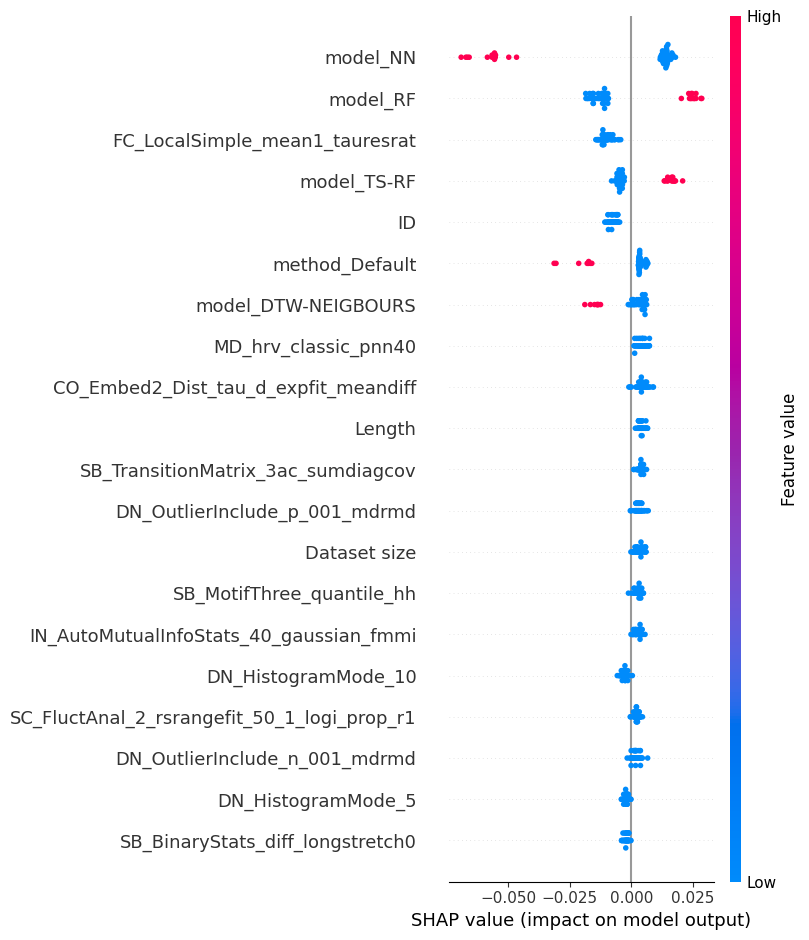

In [13]:
shap.summary_plot(shap_values, df_encoded_normalized.iloc[:50,:])